In [1]:
import numpy as np
import random
import math
import heapq
import multiprocess as mp
import talib as ta
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime,date
import time
from island_ga import IslandGGA 
from chromosome import Chromosome 
from data_preprocessing import Data
import itertools
import yfinance as yf
import datetime
from single_data_processing import SingleAssetTI

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


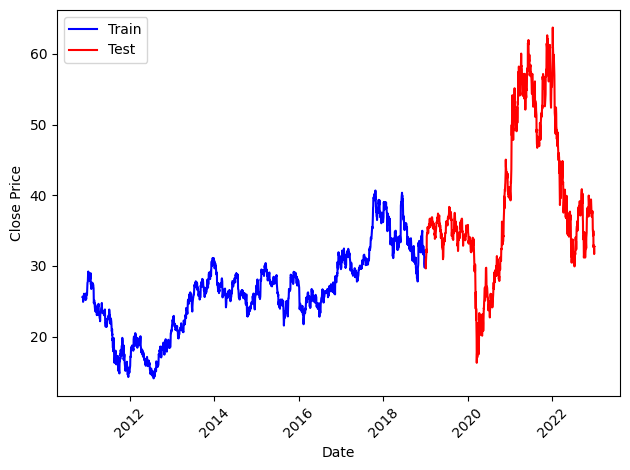

In [2]:
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2022, 12, 31)
period ="train"
ticker = 'GM'
data = SingleAssetTI(ticker, start_date, end_date,2019)
data.data_preprocess()
train_data = data.train_data    
val_data = data.test_data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

evolve_strategy = ["ring", "multikuti", "master_slave", "nearest","random","fully_connected"]
num_runs = 10
all_records = []

for strategy in evolve_strategy:
    if strategy == 'gga':
        num_islands = 1
        pop_size = 150
    else:
        num_islands = 4
        pop_size = 150

    for run in range(num_runs):

        
        ga = IslandGGA(
            data=data.train_data,
            K=2,
            num_islands=num_islands,
            m_iter=10,
            num_iter=30,
            pSize=pop_size,
            strategies=data.strategies,
            evolve_strategy=strategy
        )
        ga.evolve()
        convergence = ga.convergence_values  # assume it's a list of values over time

        for t, val in enumerate(convergence, start=1):
            all_records.append({
                'strategy': strategy,
                'run': run,
                'iteration': t,
                'value': val
            })

# Convert to DataFrame
df_convergence = pd.DataFrame(all_records)

# Save for inspection
df_convergence.to_csv("results/convergence_all_runs_migrations.csv", index=False)


Running ring
Generation 1: Best fitness = 1.2599644038621738  Average Fitness = 1.2487656451696207
Generation 2: Best fitness = 1.2599644038621738  Average Fitness = 1.2577246521236627
Generation 3: Best fitness = 1.2599644038621738  Average Fitness = 1.2599644038621733
Island 0 Migration - Left 4 - Right 1
Island 1 Migration - Left 0 - Right 2
Island 2 Migration - Left 1 - Right 3
Island 3 Migration - Left 2 - Right 4
Island 4 Migration - Left 3 - Right 0
Generation 4: Best fitness = 1.2599644038621738  Average Fitness = 1.2599644038621733
Generation 5: Best fitness = 1.2599644038621738  Average Fitness = 1.2588445279929181
Generation 6: Best fitness = 1.2599644038621738  Average Fitness = 1.2599644038621733
Island 0 Migration - Left 4 - Right 1
Island 1 Migration - Left 0 - Right 2
Island 2 Migration - Left 1 - Right 3
Island 3 Migration - Left 2 - Right 4
Island 4 Migration - Left 3 - Right 0
Generation 7: Best fitness = 1.2599644038621738  Average Fitness = 1.256542755853095
Genera

Convergence Analysis with Statistical Measures


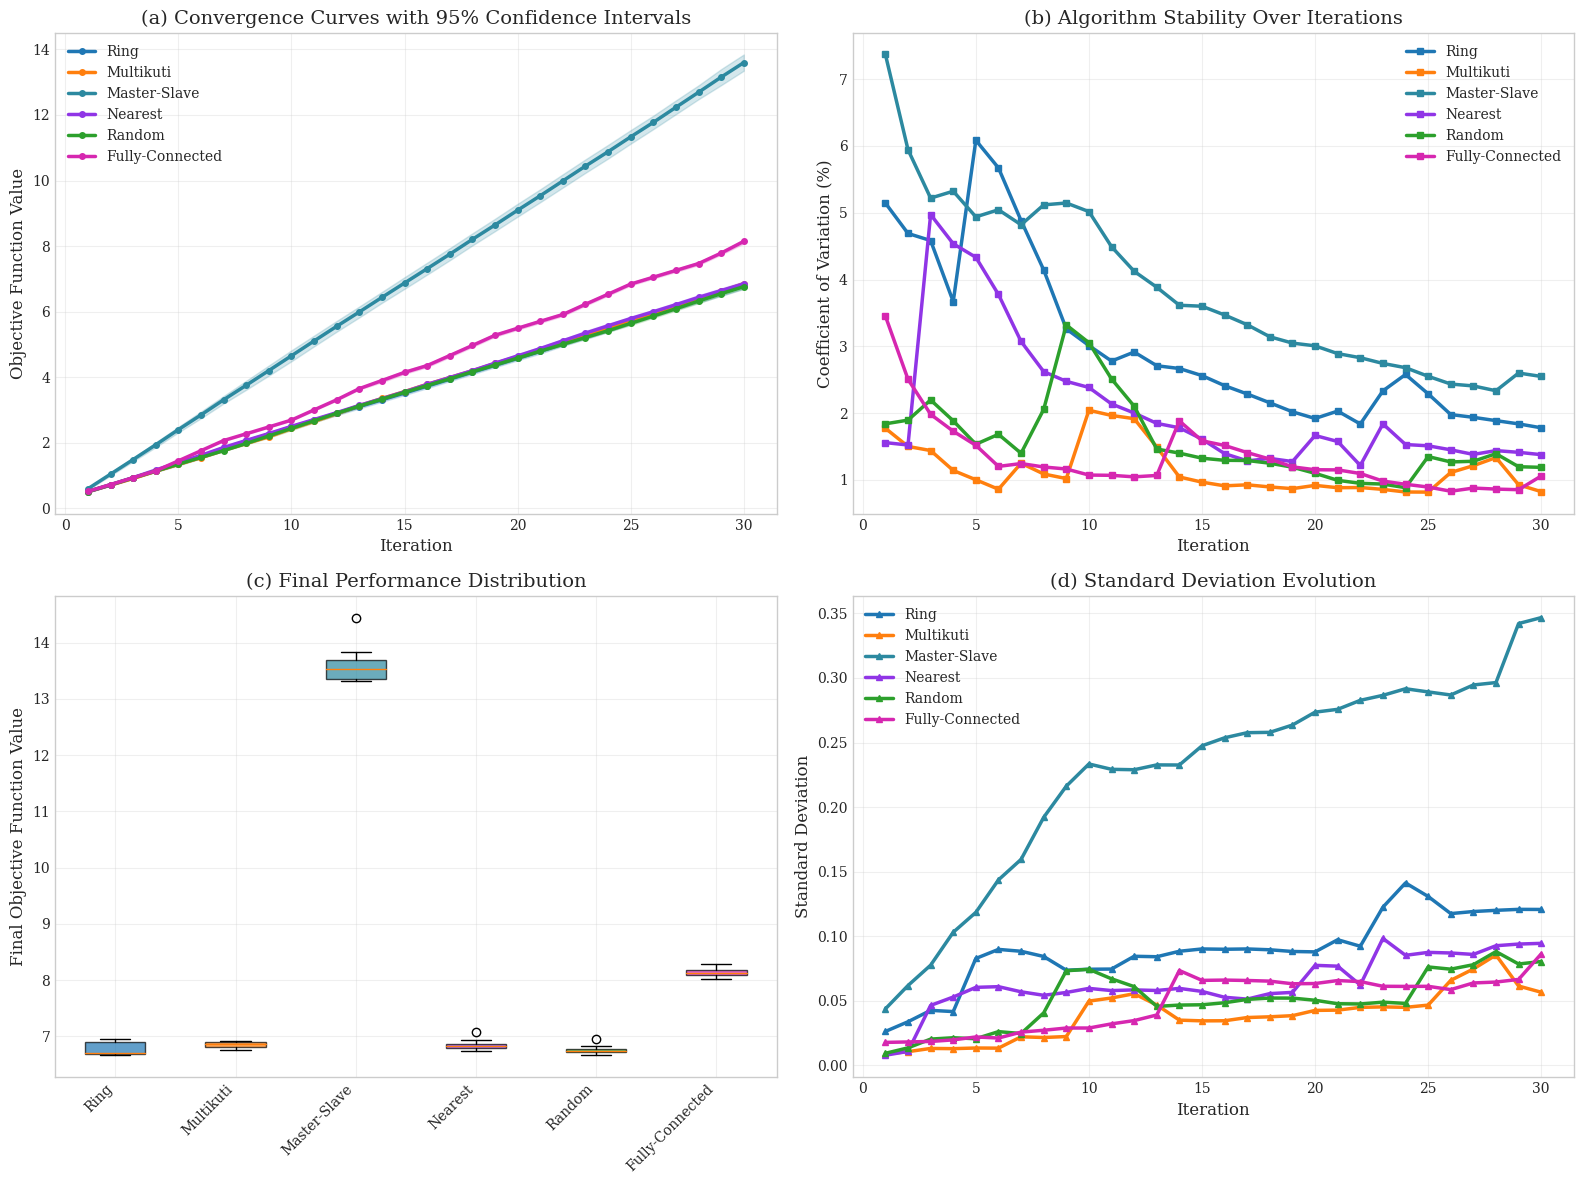

LaTeX Table for Paper:
\begin{table}[htbp]
\centering
\caption{Convergence and Stability Analysis Summary}
\label{tab:convergence_stats}
\begin{tabular}{lccccc}
\hline
Algorithm & Mean CV (\%) & Convergence Rate & Stability Trend & Final Mean & 95\% CI \\
\hline
Ring & 3.00 & 0.696 & -2.48 & 6.78 & [6.69, 6.86] \\
Multikuti & 1.16 & 0.706 & -0.35 & 6.85 & [6.81, 6.89] \\
Master-Slave & 3.86 & 1.445 & -2.75 & 13.60 & [13.35, 13.85] \\
Nearest & 2.08 & 0.706 & -1.63 & 6.85 & [6.78, 6.92] \\
Random & 1.58 & 0.695 & -0.95 & 6.76 & [6.70, 6.82] \\
Fully-Connected & 1.33 & 0.848 & -0.73 & 8.14 & [8.08, 8.20] \\
\hline
\end{tabular}
\end{table}

Summary Statistics DataFrame:
      Algorithm Mean CV (%) Convergence Rate Stability Trend Final Mean   Final 95% CI
           Ring        3.00            0.696           -2.48       6.78   [6.69, 6.86]
      Multikuti        1.16            0.706           -0.35       6.85   [6.81, 6.89]
   Master-Slave        3.86            1.445           -2.75  

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import t
import warnings
warnings.filterwarnings('ignore')

# Set publication-ready style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'font.family': 'serif'
})


from io import StringIO
df = pd.read_csv("results/convergence_time.csv")

def calculate_statistics(df):
    """Calculate comprehensive statistics for convergence analysis"""
    stats_list = []
    
    for strategy in df['strategy'].unique():
        for iteration in df['iteration'].unique():
            subset = df[(df['strategy'] == strategy) & (df['iteration'] == iteration)]
            values = subset['value'].values
            
            n = len(values)
            mean = np.mean(values)
            std = np.std(values, ddof=1)  # sample standard deviation
            var = np.var(values, ddof=1)   # sample variance
            sem = std / np.sqrt(n)         # standard error of mean
            
            # 95% confidence interval using t-distribution
            alpha = 0.05
            t_val = t.ppf(1 - alpha/2, n-1)
            ci_lower = mean - t_val * sem
            ci_upper = mean + t_val * sem
            
            # Coefficient of variation
            cv = (std / mean) * 100 if mean != 0 else 0
            
            stats_list.append({
                'strategy': strategy,
                'iteration': iteration,
                'mean': mean,
                'std': std,
                'var': var,
                'sem': sem,
                'ci_lower': ci_lower,
                'ci_upper': ci_upper,
                'cv': cv,
                'n': n
            })
    
    return pd.DataFrame(stats_list)

# Calculate statistics
stats_df = calculate_statistics(df)

# Create publication-ready plots
def create_convergence_plots():
    """Create comprehensive convergence analysis plots"""
    
    # Create figure with subplots
    fig = plt.figure(figsize=(16, 12))
    
    # Define colors for each strategy
    colors = {
        
        'multikuti': '#ff7f0e', 
        'master_slave': "#2c89a0",
        'gga': '#d62728',
        'star': '#ff7f0e', 
        'random': '#2ca02c',
        'fully_connected': "#d627b0",
        'nearest': "#9035e6",
        'ring': '#1f77b4',
    }

   

    
    # Plot 1: Mean convergence with confidence intervals
    ax1 = plt.subplot(2, 2, 1)
    for strategy in stats_df['strategy'].unique():
        strategy_data = stats_df[stats_df['strategy'] == strategy].sort_values('iteration')
        
        # Plot mean line
        ax1.plot(strategy_data['iteration'], strategy_data['mean'], 
                color=colors[strategy], linewidth=2.5, 
                label=strategy.replace('_', '-').title(), marker='o', markersize=4)
        
        # Add confidence interval
        ax1.fill_between(strategy_data['iteration'], 
                        strategy_data['ci_lower'], 
                        strategy_data['ci_upper'],
                        alpha=0.2, color=colors[strategy])
    
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Objective Function Value')
    ax1.set_title('(a) Convergence Curves with 95% Confidence Intervals')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Coefficient of Variation (Stability measure)
    ax2 = plt.subplot(2, 2, 2)
    for strategy in stats_df['strategy'].unique():
        strategy_data = stats_df[stats_df['strategy'] == strategy].sort_values('iteration')
        ax2.plot(strategy_data['iteration'], strategy_data['cv'], 
                color=colors[strategy], linewidth=2.5, 
                label=strategy.replace('_', '-').title(), marker='s', markersize=4)
    
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Coefficient of Variation (%)')
    ax2.set_title('(b) Algorithm Stability Over Iterations')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Box plots for final iteration (convergence quality)
    ax3 = plt.subplot(2, 2, 3)
    final_data = df[df['iteration'] == 30]
    strategies = final_data['strategy'].unique()
    
    box_data = []
    labels = []
    for strategy in strategies:
        values = final_data[final_data['strategy'] == strategy]['value'].values
        box_data.append(values)
        labels.append(strategy.replace('_', '-').title())
    
    bp = ax3.boxplot(box_data, labels=labels, patch_artist=True)
    for patch, strategy in zip(bp['boxes'], strategies):
        patch.set_facecolor(colors[strategy])
        patch.set_alpha(0.7)
    
    ax3.set_ylabel('Final Objective Function Value')
    ax3.set_title('(c) Final Performance Distribution')
    ax3.grid(True, alpha=0.3)
    plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')
    
    # Plot 4: Standard deviation evolution
    ax4 = plt.subplot(2, 2, 4)
    for strategy in stats_df['strategy'].unique():
        strategy_data = stats_df[stats_df['strategy'] == strategy].sort_values('iteration')
        ax4.plot(strategy_data['iteration'], strategy_data['std'], 
                color=colors[strategy], linewidth=2.5, 
                label=strategy.replace('_', '-').title(), marker='^', markersize=4)
    
    ax4.set_xlabel('Iteration')
    ax4.set_ylabel('Standard Deviation')
    ax4.set_title('(d) Standard Deviation Evolution')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    #plt.savefig('convergence_analysis.png', dpi=300, bbox_inches='tight')
    #plt.savefig('convergence_analysis.pdf', bbox_inches='tight')
    plt.show()

def create_summary_table():
    """Create summary statistics table"""
    
    # Calculate summary statistics
    summary_stats = []
    
    for strategy in stats_df['strategy'].unique():
        strategy_data = stats_df[stats_df['strategy'] == strategy]
        
        # Mean CV across all iterations (overall stability)
        mean_cv = strategy_data['cv'].mean()
        
        # Convergence rate (improvement from iter 1 to 10)
        iter1_mean = strategy_data[strategy_data['iteration'] == 1]['mean'].iloc[0]
        iter10_mean = strategy_data[strategy_data['iteration'] == 30]['mean'].iloc[0]
        convergence_rate = (iter10_mean - iter1_mean) / 9
        
        # Final performance statistics
        final_stats = strategy_data[strategy_data['iteration'] == 30].iloc[0]
        
        # Stability trend (early vs late CV)
        early_cv = strategy_data[strategy_data['iteration'] <= 10]['cv'].mean()
        late_cv = strategy_data[strategy_data['iteration'] >= 20]['cv'].mean()
        stability_trend = late_cv - early_cv
        
        summary_stats.append({
            'Algorithm': strategy.replace('_', '-').title(),
            'Mean CV (%)': f"{mean_cv:.2f}",
            'Convergence Rate': f"{convergence_rate:.3f}",
            'Stability Trend': f"{stability_trend:.2f}",
            'Final Mean': f"{final_stats['mean']:.2f}",
            'Final 95% CI': f"[{final_stats['ci_lower']:.2f}, {final_stats['ci_upper']:.2f}]"
        })
    
    summary_df = pd.DataFrame(summary_stats)
    
    # Print LaTeX table
    print("LaTeX Table for Paper:")
    print("\\begin{table}[htbp]")
    print("\\centering")
    print("\\caption{Convergence and Stability Analysis Summary}")
    print("\\label{tab:convergence_stats}")
    print("\\begin{tabular}{lccccc}")
    print("\\hline")
    print("Algorithm & Mean CV (\\%) & Convergence Rate & Stability Trend & Final Mean & 95\\% CI \\\\")
    print("\\hline")
    
    for _, row in summary_df.iterrows():
        print(f"{row['Algorithm']} & {row['Mean CV (%)']} & {row['Convergence Rate']} & {row['Stability Trend']} & {row['Final Mean']} & {row['Final 95% CI']} \\\\")
    
    print("\\hline")
    print("\\end{tabular}")
    print("\\end{table}")
    print()
    
    return summary_df

def perform_statistical_tests():
    """Perform statistical significance tests"""
    
    print("Statistical Significance Tests:")
    print("="*50)
    
    # ANOVA test for final iteration differences
    final_data = df[df['iteration'] == 30]
    groups = []
    for strategy in final_data['strategy'].unique():
        values = final_data[final_data['strategy'] == strategy]['value'].values
        groups.append(values)
    
    f_stat, p_value = stats.f_oneway(*groups)
    print(f"One-way ANOVA (final iteration):")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_value:.6f}")
    
    if p_value < 0.05:
        print("Significant differences detected between algorithms (p < 0.05)")
        
        # Pairwise t-tests with Bonferroni correction
        from itertools import combinations
        strategies = final_data['strategy'].unique()
        n_comparisons = len(list(combinations(strategies, 2)))
        alpha_corrected = 0.05 / n_comparisons
        
        print(f"\nPairwise t-tests (Bonferroni corrected α = {alpha_corrected:.4f}):")
        
        for s1, s2 in combinations(strategies, 2):
            group1 = final_data[final_data['strategy'] == s1]['value'].values
            group2 = final_data[final_data['strategy'] == s2]['value'].values
            
            t_stat, p_val = stats.ttest_ind(group1, group2)
            significant = "***" if p_val < alpha_corrected else ""
            
            print(f"{s1} vs {s2}: t={t_stat:.3f}, p={p_val:.6f} {significant}")
    
    print()

# Main execution
if __name__ == "__main__":
    print("Convergence Analysis with Statistical Measures")
    print("="*50)
    
    # Create plots
    create_convergence_plots()
    
    # Create summary table
    summary_df = create_summary_table()
    print("Summary Statistics DataFrame:")
    print(summary_df.to_string(index=False))
    print()
    
    # Perform statistical tests
    perform_statistical_tests()
    
    print("Analysis complete! Files saved:")
    print("- convergence_analysis.png (high-resolution figure)")
    print("- convergence_analysis.pdf (vector format)")
    

In [23]:
import pandas as pd
import numpy as np
from scipy.stats import t

# === Load your results ===
df = pd.read_csv("results/convergence_all_runs_migrations.csv")

def calculate_statistics(df):
    """Calculate per-strategy, per-iteration CV and confidence intervals."""
    stats_list = []
    for strategy in df['strategy'].unique():
        for iteration in df['iteration'].unique():
            subset = df[(df['strategy'] == strategy) & (df['iteration'] == iteration)]
            values = subset['value'].values
            n = len(values)
            mean = np.mean(values)
            std = np.std(values, ddof=1) if n > 1 else 0
            sem = std / np.sqrt(n) if n > 0 else 0

            if n > 1:
                t_val = t.ppf(1 - 0.05 / 2, n - 1)
                ci_lower = mean - t_val * sem
                ci_upper = mean + t_val * sem
            else:
                ci_lower = ci_upper = mean

            cv = (std / mean) * 100 if mean != 0 else 0

            stats_list.append({
                'strategy': strategy,
                'iteration': iteration,
                'mean': mean,
                'cv': cv,
                'ci_lower': ci_lower,
                'ci_upper': ci_upper
            })
    return pd.DataFrame(stats_list)

# Step 1: Calculate iteration-wise stats
stats_df = calculate_statistics(df)

# Step 2: Build summary stats for each strategy
summary_stats = []
for strategy in stats_df['strategy'].unique():
    strategy_data = stats_df[stats_df['strategy'] == strategy]

    mean_cv = strategy_data['cv'].mean()

    iter1_mean = strategy_data[strategy_data['iteration'] == 1]['mean'].iloc[0]
    iter_last_mean = strategy_data[strategy_data['iteration'] == strategy_data['iteration'].max()]['mean'].iloc[0]
    convergence_rate = (iter_last_mean - iter1_mean) / (strategy_data['iteration'].max() - 1)

    final_stats = strategy_data[strategy_data['iteration'] == strategy_data['iteration'].max()].iloc[0]

    early_cv = strategy_data[strategy_data['iteration'] <= 3]['cv'].mean()
    late_cv = strategy_data[strategy_data['iteration'] >= strategy_data['iteration'].max() - 2]['cv'].mean()
    stability_trend = late_cv - early_cv

    summary_stats.append({
        'Algorithm': strategy.replace('_', '-').title(),
        'Mean CV (%)': f"{mean_cv:.2f}",
        'Convergence Rate': f"{convergence_rate:.3f}",
        'Stability Trend': f"{stability_trend:.2f}",
        'Final Mean': f"{final_stats['mean']:.2f}",
        'Final 95% CI': f"[{final_stats['ci_lower']:.2f}, {final_stats['ci_upper']:.2f}]"
    })

summary_df = pd.DataFrame(summary_stats)

# Step 3: Print summary DataFrame
print("Summary Statistics:")
print(summary_df.to_string(index=False))

# Step 4: Create LaTeX table
print("\nLaTeX Table for Paper:")
print("\\begin{table}[htbp]")
print("\\centering")
print("\\caption{Convergence and Stability Analysis Summary}")
print("\\label{tab:convergence_stats}")
print("\\begin{tabular}{lccccc}")
print("\\hline")
print("Algorithm & Mean CV (\\%) & Convergence Rate & Stability Trend & Final Mean & 95\\% CI \\\\")
print("\\hline")
for _, row in summary_df.iterrows():
    print(f"{row['Algorithm']} & {row['Mean CV (%)']} & {row['Convergence Rate']} & {row['Stability Trend']} & {row['Final Mean']} & {row['Final 95% CI']} \\\\")
print("\\hline")
print("\\end{tabular}")
print("\\end{table}")


Summary Statistics:
      Algorithm Mean CV (%) Convergence Rate Stability Trend Final Mean     Final 95% CI
           Ring        3.01            0.218           -4.52      22.05   [21.83, 22.27]
      Multikuti        2.65            0.219          -11.74      22.18   [22.06, 22.29]
   Master-Slave        3.34            0.469           -6.78      47.03   [46.42, 47.63]
        Nearest      222.62            0.775          166.42      77.23  [14.63, 139.84]
         Random      159.42            2.281          162.47     226.31  [38.21, 414.40]
Fully-Connected      130.48            1.110          210.52     110.45 [-16.12, 237.01]

LaTeX Table for Paper:
\begin{table}[htbp]
\centering
\caption{Convergence and Stability Analysis Summary}
\label{tab:convergence_stats}
\begin{tabular}{lccccc}
\hline
Algorithm & Mean CV (\%) & Convergence Rate & Stability Trend & Final Mean & 95\% CI \\
\hline
Ring & 3.01 & 0.218 & -4.52 & 22.05 & [21.83, 22.27] \\
Multikuti & 2.65 & 0.219 & -11.74 & 2

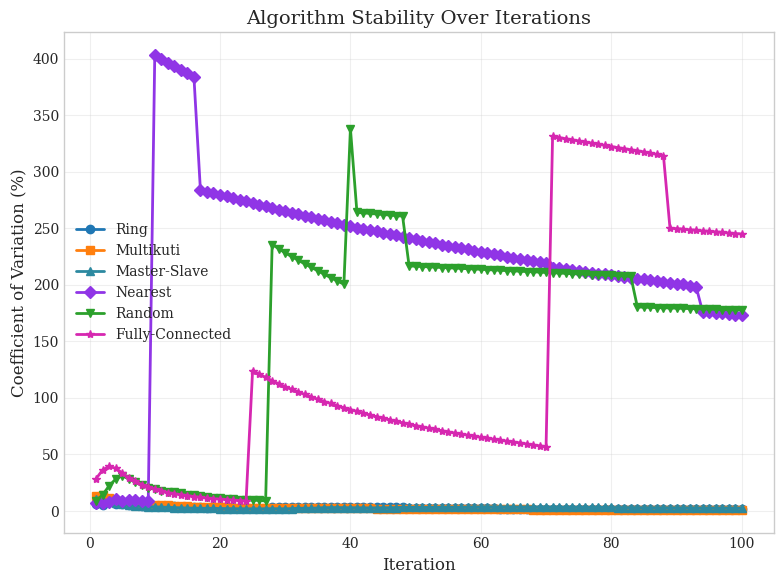

In [24]:
import matplotlib.pyplot as plt

# Colors (consistent with earlier)
colors = {
    'multikuti': '#ff7f0e', 
    'master_slave': "#2c89a0",
    'gga': '#d62728',
    'star': '#ff7f0e', 
    'random': '#2ca02c',
    'fully_connected': "#d627b0",
    'nearest': "#9035e6",
    'ring': '#1f77b4',
}

# Marker cycle
markers = ['o', 's', '^', 'D', 'v', '*', 'P', 'X']  # 8 distinct markers

# Plot CV over iterations
plt.figure(figsize=(8, 6))

for idx, strategy in enumerate(stats_df['strategy'].unique()):
    strategy_data = stats_df[stats_df['strategy'] == strategy].sort_values('iteration')
    plt.plot(strategy_data['iteration'], strategy_data['cv'],
             color=colors.get(strategy, 'black'),
             linewidth=2,
             marker=markers[idx % len(markers)],
             markersize=6,
             label=strategy.replace('_', '-').title())

plt.xlabel('Iteration')
plt.ylabel('Coefficient of Variation (%)')
plt.title('Algorithm Stability Over Iterations')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


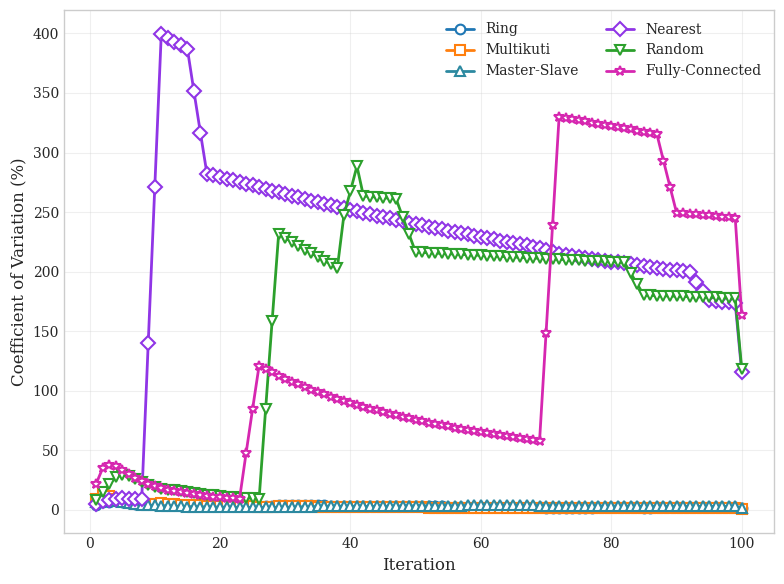

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Marker styles
markers = ['o', 's', '^', 'D', 'v', '*', 'P', 'X']  # 8 distinct markers

# Optional: smoothing function
def smooth_curve(y, box_pts=3):
    box = np.ones(box_pts)/box_pts
    return np.convolve(y, box, mode='same')

plt.figure(figsize=(8, 6))

for idx, strategy in enumerate(stats_df['strategy'].unique()):
    strategy_data = stats_df[stats_df['strategy'] == strategy].sort_values('iteration')
    
    # Optional smoothing
    y_smoothed = smooth_curve(strategy_data['cv'], box_pts=3)
    
    plt.plot(strategy_data['iteration'], y_smoothed,
             color=colors.get(strategy, 'black'),
             linewidth=2,
             marker=markers[idx % len(markers)],
             markersize=7,
             markerfacecolor='white',  # white fill
             markeredgewidth=1.5,       # thicker outline
             label=strategy.replace('_', '-').title())

plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Coefficient of Variation (%)', fontsize=12)
#plt.title('Algorithm Stability Over Iterations', fontsize=14)
plt.legend(fontsize=10, ncol=2, frameon=False)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
